In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import json
import torch
import numpy as np
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
from nerfstudio.utils.eval_utils import eval_setup
from plane_nerf.inerf_trainer import load_data_into_trainer
from plane_nerf.inerf_utils import inerf
from plane_nerf.inerf_utils import load_eval_image_into_pipeline

In [3]:
os.chdir('/workspace')
MODEL_PATH = "/workspace/outputs/jackal_color_wheel_training_data_1/plane-nerf/2024-02-19_174621"
DATA_PATH = "/stored_data/jackal_one_frame_color"
GROUND_TRUTH_PATH = os.path.join(DATA_PATH, "ground_truth.json")
config_path = os.path.join(MODEL_PATH, "config.yml")
config, pipeline, _, _ = eval_setup(
                        Path(config_path),
                        test_mode="inference",
                    )
transform_file_path = os.path.join(DATA_PATH, "transforms.json")
with open(os.path.join(DATA_PATH, transform_file_path)) as f:
    transform = json.load(f)

pipeline = load_eval_image_into_pipeline(pipeline,DATA_PATH,transform)

config.pipeline.datamanager.pixel_sampler.num_rays_per_batch = 4096 

trainer = load_data_into_trainer(
    config,
    pipeline,
    plane_optimizer = True
)
trainer.pipeline.datamanager.KERNEL_SIZE = 5
trainer.pipeline.datamanager.THRESHOLD = 40
trainer.pipeline.datamanager.METHOD = "sift"

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from 
outputs/jackal_color_wheel_training_data_1/plane-nerf/2024-02-19_174621/nerfstudio_models/step-000009999.ckpt

/workspace/plane-nerf/plane_nerf/inerf_utils.py:158: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  camera_to_worlds = torch.cat([camera_to_worlds, tensor([tf]).float()], 0)


Setting up training dataset...

Caching all 1 images.

Output()

Loading PlaneNerfCameraOptimizer


[17:13:17] Saving checkpoints to:                                                                         ]8;id=259191;file:///usr/local/lib/python3.10/dist-packages/nerfstudio/engine/trainer.py\trainer.py]8;;\:]8;id=553146;file:///usr/local/lib/python3.10/dist-packages/nerfstudio/engine/trainer.py#136\136]8;;\
           outputs/jackal_color_wheel_training_data_1/plane-nerf/2024-02-19_174621/nerfstudio_models                    

Loading latest Nerfstudio checkpoint from load_dir...


Done loading Nerfstudio checkpoint from 
outputs/jackal_color_wheel_training_data_1/plane-nerf/2024-02-19_174621/nerfstudio_models/step-000009999.ckpt

In [4]:
with open(GROUND_TRUTH_PATH) as f:
    ground_truth_transform = json.load(f)
ground_truth_poses = []
tf = ground_truth_transform["frames"][0]["transform_matrix"]
tf = np.asarray(tf)
tf = tf[:3, :4 ]
ground_truth_poses.append(tf)
ground_truth_poses = torch.tensor(ground_truth_poses).to(trainer.pipeline.device)

In [5]:
import time
start = time.time()
ans = inerf(trainer,GROUND_TRUTH_POSE=ground_truth_poses)
end = time.time()
print("Time taken for inference: ", end-start)

Number of keypoints:  85
Number of rays:  4113
Reduce the number of rays
Final number of rays:  4096
Time taken for inference:  81.0102162361145


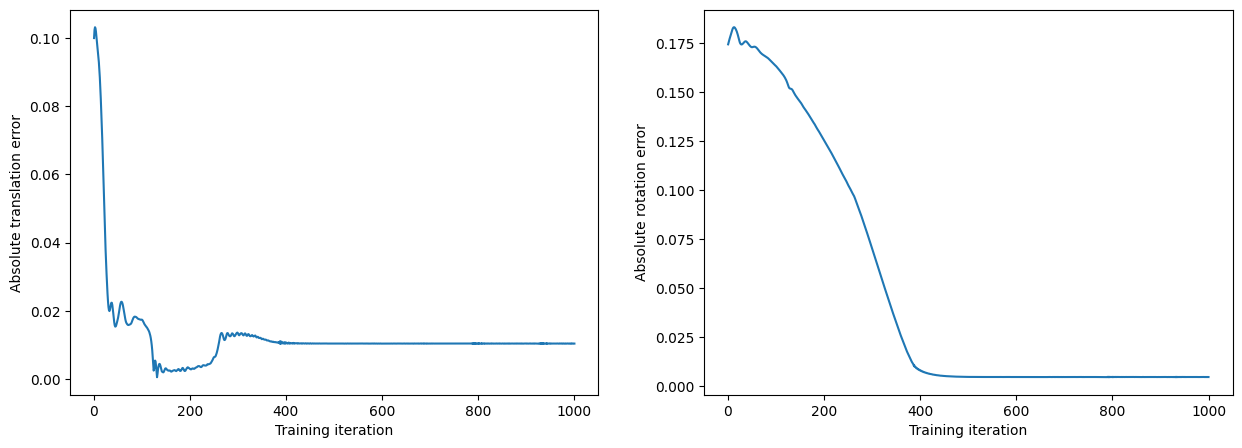

In [6]:
#Plot store_t_diff and store_r_diff with  respect to training iteration in 2 subplots

plotting_data = np.asarray(ans["store"].to("cpu"))
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(plotting_data[:, 0], plotting_data[:, 1])
plt.xlabel("Training iteration")
plt.ylabel("Absolute translation error")
plt.subplot(1, 2, 2)
plt.plot(plotting_data[:, 0], plotting_data[:, 2])
plt.xlabel("Training iteration")
plt.ylabel("Absolute rotation error")
plt.show()